In [300]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import wikipedia
import warnings
import random

from bs4 import BeautifulSoup
import requests
import re
from fuzzywuzzy import fuzz

In [2]:
df_music = pd.read_csv('../music_data/dataset-12-1.csv')

In [3]:
df_music.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,987.000000,987.000000,987,987,987.000000,9.870000e+02,987.000000
unique,NaN,NaN,543,975,NaN,NaN,NaN
top,NaN,NaN,The Beatles,Dedicated To The One I Love,NaN,NaN,NaN
freq,NaN,NaN,23,2,NaN,NaN,NaN
mean,50.496454,11.708669,NaN,NaN,1964.513678,8.002504e+06,3367.725431
std,28.955074,12.776220,NaN,NaN,2.879346,2.003319e+07,3953.667139
min,1.000000,4.786301,NaN,NaN,1960.000000,1.728000e+03,108.000000
25%,25.000000,5.761896,NaN,NaN,1962.000000,2.501365e+05,951.000000
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.563520e+05,1953.000000
75%,75.500000,11.949771,NaN,NaN,1967.000000,5.058133e+06,4194.000000


# 0 Utility

In [4]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [5]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Baseline

In [6]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


In [7]:
do_log(df_music, feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount'])

In [8]:
z_score_norm(df_music, feature_list=['Rank', 'RankPowerlaw', 'Year', 'WikiWordCount'])

In [9]:
feature = df_music.loc[:,['RankPowerlaw', 'Year', 'WikiWordCount']]
target  = df_music.loc[:,['SpotifyPlayCount']]

In [10]:
lr = linear_model.LinearRegression()

In [11]:
reg = linear_model.Ridge (alpha = .8)

This is the plots/reports of LinearRegression


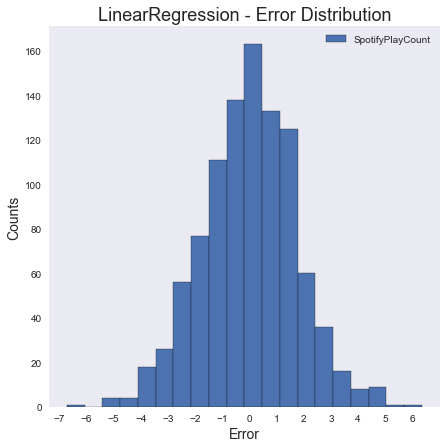

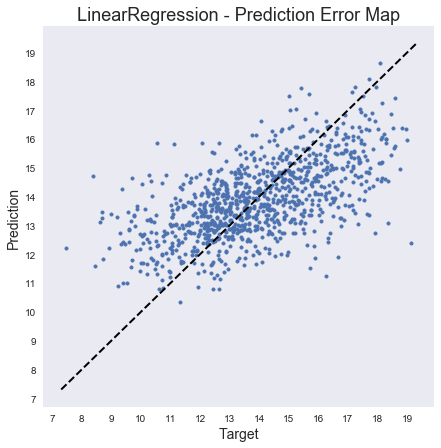

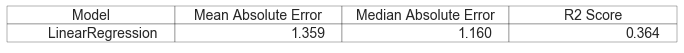

In [12]:
evaluation(lr, feature, target)

In [13]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)  # default is 10-fold

# Twenty Best

In [14]:
best = target - pred

In [15]:
best.insert(0, 'Prediction', pred)

In [16]:
best.insert(0, 'Target', target)

In [17]:
best.describe()

,Target,Prediction,SpotifyPlayCount
count,987.000000,987.000000,987.000000
mean,13.894324,13.896237,-0.001914
std,2.169542,1.314378,1.729986
min,7.454720,10.356239,-6.344982
25%,12.429750,12.999553,-1.173167
50%,13.770881,13.796711,-0.077178
75%,15.436479,14.753006,1.148544
max,19.119101,18.645882,6.719538


In [18]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index

In [19]:
best.nlargest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
826,19.119101,12.399562,6.719538
91,18.355697,13.073865,5.281832
259,17.907229,12.733936,5.173293
125,16.255563,11.233304,5.022259
180,16.674597,11.904866,4.769731
276,17.717049,13.351527,4.365522
842,17.322973,13.051946,4.271027
872,17.636537,13.412611,4.223926
230,15.707082,11.514579,4.192503
179,15.887576,11.870127,4.017449


In [20]:
df_music.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
826,1.260696,-0.897742,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,0.863502,19.119101,-1.174632
91,1.018942,-0.806925,Sam Cooke,Wonderful World,-1.567605,18.355697,0.368054
259,0.431826,-0.548283,Ben E. King,Stand By Me,-1.220304,17.907229,-0.296113
125,0.017391,-0.319503,Billy Bland,Let The Little Girl Dance,-1.567605,16.255563,-1.928709
180,1.640595,-1.026644,Maurice Williams and the Zodiacs,Stay,-1.567605,16.674597,-0.879462
276,1.536986,-0.992983,Dave Brubeck,Take Five,-1.220304,17.717049,0.584854
842,-0.086218,-0.253867,Scott Mckenzie,San Francisco (Be Sure to Wear Flowers in Your...,0.863502,17.322973,-0.934510
872,1.053478,-0.820375,Cream,White Room,1.210803,17.636537,-0.370465
230,-0.362508,-0.056471,Marcels,Blue Moon,-1.220304,15.707082,-1.803164
179,1.606059,-1.015540,Barrett Strong,Money,-1.567605,15.887576,-0.919181


In [21]:
lr2 = linear_model.LinearRegression()

In [22]:
lr2.fit(feature, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
feature.head()

,RankPowerlaw,Year,WikiWordCount
0,3.937389,-1.567605,-0.494041
1,3.186936,-1.567605,0.734592
2,2.747948,-1.567605,0.705613
3,0.254995,-1.567605,0.705613
4,-0.662354,-1.567605,0.705613


In [24]:
lr2.coef_

array([[ 0.59059588,  0.40435267,  1.02011652]])

# Twenty Worst

In [25]:
best.nsmallest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
737,8.377471,14.722454,-6.344982
578,10.539509,15.873371,-5.333862
864,9.691964,14.651270,-4.959306
515,9.375601,14.253891,-4.878290
519,8.679822,13.454378,-4.774556
227,7.454720,12.209741,-4.755021
715,11.114401,15.813829,-4.699428
520,8.678632,13.258019,-4.579388
174,8.603371,13.105400,-4.502030
959,10.271043,14.732205,-4.461162


In [26]:
worst_index = best.nsmallest(20, columns='SpotifyPlayCount').index

In [27]:
df_music.iloc[worst_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
737,1.709667,-1.048517,Paul Revere and The Raiders,Let Me,1.558105,8.377471,0.718370
578,0.224608,-0.439925,The Temptations,"Run Away Child, Running Wild",1.558105,10.539509,1.511440
864,1.433377,-0.958242,Bill Cosby,Little Ole Man (Uptight-Everything's Alright),0.863502,9.691964,1.030056
515,-1.087770,0.749516,The Ray Charles Singers,Love Me with All Your Heart (Cuando Calienta E...,-0.178401,9.375601,-0.039515
519,0.569971,-0.614930,The Dave Clark Five,Can't You See That She's Mine,-0.178401,8.679822,-0.030932
227,-0.500653,0.057600,Linda Scott,Don't Bet Money Honey,-1.220304,7.454720,-1.181268
715,-1.329524,1.247041,Roger Williams,Born Free,0.516201,11.114401,0.915937
520,1.398841,-0.946409,The Dave Clark Five,Do You Love Me,-0.178401,8.678632,-0.030932
174,1.295232,-0.910115,Annette Funicello,O Dio Mio,-1.567605,8.603371,0.207344
959,-0.327972,-0.083205,Bobby Sherman,Little Woman,1.558105,10.271043,0.240497


# 2 One Hot Encoding

In [252]:
df = pd.DataFrame({'Genre':['pop', 'r&b', 'country','pop', 'r&b', 'country','folk', 'rock and row'],
                   'WordCount': np.random.randn(8,)})

In [253]:
df

,Genre,WordCount
0,pop,0.590215
1,r&b,-0.213398
2,country,0.760691
3,pop,-0.133835
4,r&b,0.060788
5,country,-0.418949
6,folk,1.199795
7,rock and row,0.026890


In [254]:
pd.get_dummies(df.Genre)

,country,folk,pop,r&b,rock and row
0,0,0,1,0,0
1,0,0,0,1,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0
5,1,0,0,0,0
6,0,1,0,0,0
7,0,0,0,0,1


# 3 Add Followers and PopIndex to Dataframe

In [351]:
df_music = pd.read_csv('../music_data/dataset-12-3.csv')

In [352]:
df_music = df_music.drop(['URL', 'external_urls', 'genres'], axis=1)

In [353]:
df_music.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,followers,popularity
count,987.000000,987.000000,987.000000,9.870000e+02,987.000000,9.870000e+02,987.000000
mean,50.496454,11.708669,1964.513678,8.002504e+06,3359.658561,3.067930e+05,50.727457
std,28.955074,12.776220,2.879346,2.003319e+07,3957.353059,8.630806e+05,19.093867
min,1.000000,4.786301,1960.000000,1.728000e+03,108.000000,1.900000e+01,4.000000
25%,25.000000,5.761896,1962.000000,2.501365e+05,951.000000,4.208000e+03,36.000000
50%,50.000000,7.562751,1965.000000,9.563520e+05,1952.000000,2.786600e+04,52.000000
75%,75.500000,11.949771,1967.000000,5.058133e+06,4169.000000,1.207250e+05,65.000000
max,100.000000,100.000000,1969.000000,2.010574e+08,19546.000000,5.042014e+06,89.000000


In [356]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,followers,popularity
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180,9877,52
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,59717,59
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,120725,63
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,120725,63
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,120725,63


In [358]:
df_music.to_csv('../music_data/dataset-12-4.csv', index=False)

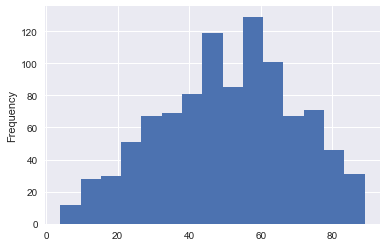

In [330]:
df_music.popularity.plot.hist(bins=15)

In [334]:
df_music2 = df_music.copy()

In [335]:
df_music2.rename(columns={'followers':'Followers', 'popularity':'Popularity'}, inplace=True)

Do log to the following features:
1. SpotifyPlayCount (target)
2. RankPowerlaw
3. WikiWordCount
4. Followers

In [336]:
df_music2.SpotifyPlayCount = np.log(df_music2.SpotifyPlayCount)
df_music2.RankPowerlaw = np.log(df_music2.Followers)
df_music2.WikiWordCount = np.log(df_music2.WikiWordCount)
df_music2.Followers = np.log(df_music2.Followers)

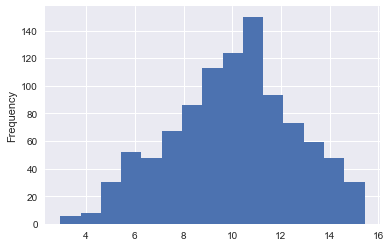

In [337]:
df_music2.Followers.plot.hist(bins=15)

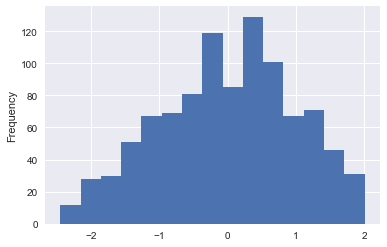

In [354]:
df_music2.Popularity.plot.hist(bins=15)

In [338]:
df_music2.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
0,1,9.197964,Percy Faith,"Theme From ""A Summer Place""",1960,15.425179,7.073270,9.197964,52
1,2,10.997372,Jim Reeves,He'll Have To Go,1960,15.291952,8.352319,10.997372,59
2,3,11.701271,The Everly Brothers,Cathy's Clown,1960,15.246003,8.322151,11.701271,63
3,30,11.701271,The Everly Brothers,Let It Be Me,1960,13.455567,8.322151,11.701271,63
4,70,11.701271,The Everly Brothers,So Sad,1960,13.597689,8.322151,11.701271,63


In [339]:
df_music2.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
count,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000
mean,50.496454,10.038611,1964.513678,13.894324,7.579075,10.038611,50.727457
std,28.955074,2.608189,2.879346,2.169542,1.049942,2.608189,19.093867
min,1.000000,2.944439,1960.000000,7.454720,4.682131,2.944439,4.000000
25%,25.000000,8.344743,1962.000000,12.429750,6.857514,8.344743,36.000000
50%,50.000000,10.235163,1965.000000,13.770881,7.576610,10.235163,52.000000
75%,75.500000,11.701271,1967.000000,15.436479,8.335431,11.701271,65.000000
max,100.000000,15.433316,1969.000000,19.119101,9.880526,15.433316,89.000000


Do z-score to the following feature
1. RankPowerlaw
2. WikiWordCount
3. Followers
4. Popularity

In [341]:
feature_list = ['RankPowerlaw', 'WikiWordCount', 'Followers', 'Popularity']
z_score_norm(df_music2, feature_list)

In [344]:
z_score_norm(df_music2, ['Year'])

In [345]:
df_music2.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
count,987.000000,9.870000e+02,9.870000e+02,987.000000,9.870000e+02,9.870000e+02,9.870000e+02
mean,50.496454,-1.264102e-15,-2.273449e-14,13.894324,3.276451e-15,-1.264102e-15,-1.842779e-16
std,28.955074,1.000000e+00,1.000000e+00,2.169542,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-2.719960e+00,-1.567605e+00,7.454720,-2.759147e+00,-2.719960e+00,-2.447250e+00
25%,25.000000,-6.494420e-01,-8.730030e-01,12.429750,-6.872390e-01,-6.494420e-01,-7.713187e-01
50%,50.000000,7.535957e-02,1.689002e-01,13.770881,-2.347950e-03,7.535957e-02,6.664669e-02
75%,75.500000,6.374767e-01,8.635024e-01,15.436479,7.203795e-01,6.374767e-01,7.474936e-01
max,100.000000,2.068372e+00,1.558105e+00,19.119101,2.191980e+00,2.068372e+00,2.004442e+00


In [346]:
target = df_music2.loc[:,'SpotifyPlayCount']
feature_list = ['RankPowerlaw', 'WikiWordCount', 'Followers', 'Popularity', 'Year']
feature = df_music2.loc[:, feature_list]

In [349]:
lr = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


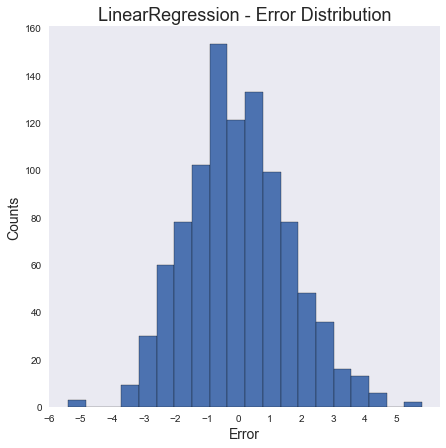

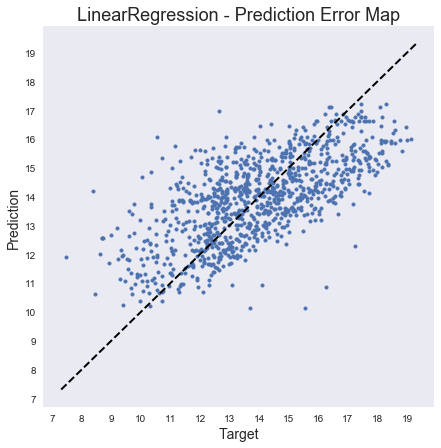

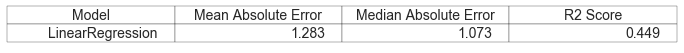

In [350]:
evaluation(lr, feature, target)

In [305]:
df_genre = df_genre[['Title', 'GenreRaw']]